# **Voice of Customer Analysis**
**Subject**: BADS 7105 - CRM Analytics and Intelligence

**Student** : Phannita Thianthammachat

**ID** : 6310412026

# **Step 0 - install and import dependencies**

In [135]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

In [136]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections

In [137]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [138]:
# Mounting Google Drive locally
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [139]:
df = pd.read_csv("/content/drive/My Drive/BADS7105 CRM/VoC/Wongnai Reviews - Small.csv")

In [140]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


# **Step 1 - document embedding and dimension reduction**

In [141]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993827,  0.01941084,  0.03787038, ..., -0.03488849,
         0.06299512,  0.04635989],
       [ 0.00634244,  0.00814594,  0.03071941, ..., -0.01478723,
        -0.03080936, -0.03316405],
       [ 0.0633687 , -0.02027139, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439987],
       ...,
       [ 0.08775924,  0.03609736,  0.01263062, ..., -0.03102781,
        -0.03361677,  0.01928871],
       [ 0.05691195,  0.05381691, -0.0399575 , ..., -0.06598807,
        -0.05390478, -0.01037725],
       [ 0.0777048 ,  0.05080631,  0.02680681, ..., -0.0061413 ,
        -0.01313567,  0.02236264]], dtype=float32)

In [142]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=50)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

# **Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

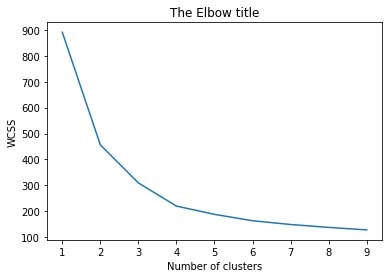

In [178]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [179]:
#run kmeans with no. of clusters you see fit the most

k = 3

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [180]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [181]:
df_kmeans

,KMeans ID,texts
0,0,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...
1,1,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
2,2,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...


In [182]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*']/g"

specialchar_pattern = re.compile(special_characters)

In [183]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [184]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [185]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [186]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [187]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

In [188]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', 'ร้าน','บาท','ทาน','กิน','นะ','ค่ะ','นะคะ', 'นะค่ะ', 'เค้า', 'ถ้า', 'ผม', 'ดิชั้น', 'ดิ', 'เกริ่น','อิอิ', 'อ่ะค่ะ','[', 'น', 'ร้า', 
                 'กก', 'tamp', '(', ')', "'",'.','คนนึงน่ารัก','คนนึง','นึง', 'รีวิว',"['", 'สวัสดี']
screening_words = stopwords + removed_words

new_words = {'สตารบัก', 'Kasetsart', 'ทรูคอฟฟี่', 'เอ๊กซ์เพรสโซ่ไอซ์', 'ลาเต้ไอซ', 'คาราเมล มัคคิอาโต้' ,'คาราเมลแมคคิอัตโต้', 'อิตาเลียนโซดา', 'อเมซอน','มาม่า','ไข่มุก', 'Black Canyon',
             'แพงเกิ๊น', 'อร่อยมากกกกก', 'วาซาบิ', 'แซ่บเว่อร์','แซ่บซี๊ด','แมคคาดีเมีย', 'น้ำสัปปะรด', 'น้ำแอปเปิ้ล', 'น้ำแครอท', 'น้ำผลไม้', 'โฮมเมด', 'Ochaya', 'โชยุ', 'ซูชิ', 'ริมทะเล'}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

df['Review_tokenized'] = df['Review'].apply(lambda x: tokenize_to_list(x))
df.head()

,Review ID,Review,KMeans ID,Review_tokenized,Agglomerative ID
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...,0,"[คน, ชอบ, , Macchiato, , เป็นประจำ, , เดิน,...",0
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...,0,"[Art, , of, , Coffee, , Kasetsart, , ร้านก...",0
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...,1,"[กวง, ทะเล, เผา, , อาหารทะเล, สด, เนื้อ, ปู, ...",0
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,1,"[มีโอกาส, ตื่น, เช้า, โอกาส, มาหา, อร่อย, ตอนเ...",0
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...,1,"[ชอบ, อาหาร, เวียดนาม, บ้าน, , ซอย, ราชครู, เ...",0


In [189]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [190]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[คน, ชอบ, Macchiato, เป็นประจำ, เด, ArtofCoffe...","[(ร้านกาแฟ, 25), (กาแฟ, 22), (ชอบ, 9), (คาเฟ่,..."
1,1,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คว...,"[กวง, ทะเล, เผา, อาหารทะเล, สด, เนื้อ, ปู, หวา...","[(ร้านอาหาร, 14), (อร่อย, 11), (อาหาร, 10), (บ..."
2,2,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[ไหม, ไหม, หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า,...","[(ชา, 18), (นม, 14), (ไข่มุก, 14), (เครื่องดื่..."


In [191]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('ร้านกาแฟ', 25), ('กาแฟ', 22), ('ชอบ', 9), ('คาเฟ่', 6), ('แวะ', 6), ('ดี', 6), ('รี่', 5), ('อร่อย', 5), ('กา', 5), ('น่ารัก', 5)]

Cluster ID : 1

Most common words include : [('ร้านอาหาร', 14), ('อร่อย', 11), ('อาหาร', 10), ('บ้าน', 6), ('ส้มตำ', 6), ('ซอย', 6), ('สาขา', 6), ('กาแฟ', 6), ('เพื่อน', 5), ('ไทย', 5)]

Cluster ID : 2

Most common words include : [('ชา', 18), ('นม', 14), ('ไข่มุก', 14), ('เครื่องดื่ม', 4), ('น้ำ', 3), ('ตั้งอยู่', 3), ('ลอง', 3), ('เดิน', 3), ('ปั่น', 3), ('ไต้หวัน', 3)]



# **Step 3 - document clustering using Agglomorative Clustering with cosine similarity**

In [192]:
#clustering using agglomorative clustering

knn_graph = kneighbors_graph(embed_comments_array, 5, include_self=False)
model = AgglomerativeClustering(linkage="average", connectivity=knn_graph, n_clusters=10, affinity="cosine")
model.fit(embed_comments_array)
df['Agglomerative ID'] = model.labels_

In [193]:
#merge all reviews of each cluster into one big sentence 

df_Agglomerative = pd.DataFrame(columns=["Agglomerative ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(str(df['Review'][df['Agglomerative ID'] == i].tolist()))
  df_Agglomerative.loc[len(df_Agglomerative)] = row

In [194]:
#clean and tokenize sentences. count the occurences of each word

df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_Agglomerative['texts'] = df_Agglomerative['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_Agglomerative['texts_tokenized'] = df_Agglomerative['texts'].apply(lambda x: tokenize_to_list(x))
df_Agglomerative['texts_count'] = df_Agglomerative['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [195]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_Agglomerative)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_Agglomerative['texts_count'][i])[:top_N_words]}\n")

Cluster ID : 0

Most common words include : [('อร่อย', 505), ('รสชาติ', 407), ('ดี', 346), ('กาแฟ', 311), ('เมนู', 309), ('สั่ง', 301), ('อาหาร', 285), ('ราคา', 273), ('ชา', 262), ('ชอบ', 229)]

Cluster ID : 1

Most common words include : [('แตงโม', 22), ('น้ำ', 8), ('ปั่น', 6), ('เนื้อ', 6), ('เลือก', 4), ('ซื้อ', 4), ('ดื่ม', 4), ('พันธุ์', 3), ('รับประทาน', 3), ('แก้', 3)]

Cluster ID : 2

Most common words include : [('แย่มาก', 3), ('โต๊ะ', 2), ('รอง', 2), ('แก้ว', 2), ('ช้ัน', 1), ('ทบ', 1), ('อาหาร', 1), ('เวลา', 1), ('โมง', 1), ('เย็น', 1)]



# **Step 4 - result discussion**

**Cluster 0** : คาเฟ่ ร้านกาแฟ : รีวิวเป็นไปในทางที่ดี มีหัวข้อที่รีวิวเกี่ยวกับรสชาติ, ราคา, เมนู

**Cluster 1** : ร้านอาหาร, ร้านอาหารไทย : รีวิวเป็นไปในทางที่ดี มีหัวข้อที่รีวิวเกี่ยวกับรสชาติ, ส้มตำ, น้ำแตงโมปั่น

**Cluster 2** : ร้านชานมไข่มุก : รีวิวเป็นไปในทางที่ไม่ดี (Keywords : "แย่มาก"), มีหัวข้อที่รีวิวเกี่ยวกับที่ตั้งของร้าน